# Convert and Optimize YOLOv7 with OpenVINO™

The YOLOv7 algorithm is making big waves in the computer vision and machine learning communities.
It is a real-time object detection algorithm that performs image recognition tasks by taking an image as input 
and then predicting bounding boxes and class probabilities for each object in the image.

YOLO stands for “You Only Look Once”, it is a popular family of real-time object detection algorithms.
The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency.
YOLOv7 is next stage of evolution of YOLO models family, which provides a greatly improved real-time object detection accuracy without increasing the inference costs.
More details about its realization can be found in original model [paper](https://arxiv.org/abs/2207.02696) and [repository](https://github.com/WongKinYiu/yolov7)

Real-time object detection is often used as a key component in computer vision systems.
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLO V7 with OpenVINO.

The tutorial consists of the following steps:

- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to ONNX
- Convert ONNX model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.


### Table of content:
- [Get Pytorch model](#Get-Pytorch-model-Uparrow)
- [Prerequisites](#Prerequisites-Uparrow)
- [Check model inference](#Check-model-inference-Uparrow)
- [Export to ONNX](#Export-to-ONNX-Uparrow)
- [Convert ONNX Model to OpenVINO Intermediate Representation (IR)](#Convert-ONNX-Model-to-OpenVINO-Intermediate-Representation-(IR)-Uparrow)
- [Verify model inference](#Verify-model-inference-Uparrow)
    - [Preprocessing](#Preprocessing-Uparrow)
    - [Postprocessing](#Postprocessing-Uparrow)
    - [Select inference device](#Select-inference-device-Uparrow)
- [Verify model accuracy](#Verify-model-accuracy-Uparrow)
    - [Download dataset](#Download-dataset-Uparrow)
    - [Create dataloader](#Create-dataloader-Uparrow)
    - [Define validation function](#Define-validation-function-Uparrow)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API-Uparrow)
- [Validate Quantized model inference](#Validate-Quantized-model-inference-Uparrow)
- [Validate quantized model accuracy](#Validate-quantized-model-accuracy-Uparrow)
- [Compare Performance of the Original and Quantized Models](#Compare-Performance-of-the-Original-and-Quantized-Models-Uparrow)

## Get Pytorch model [$\Uparrow$](#Table-of-content:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv7 tiny model pre-trained on a COCO dataset, which is available in this [repo](https://github.com/WongKinYiu/yolov7).
Typical steps to obtain pre-trained model:

1. Create instance of model class.
2. Load checkpoint state dict, which contains pre-trained model weights.
3. Turn model to evaluation for switching some operations to inference mode.

In this case, the model creators provide a tool that enables converting the YOLOv7 model to ONNX, so we do not need to do these steps manually.

## Prerequisites [$\Uparrow$](#Table-of-content:)


In [1]:
import sys
from pathlib import Path
sys.path.append("../utils")
from notebook_utils import download_file

In [2]:
# Clone YOLOv7 repo
if not Path('yolov7').exists():
    !git clone https://github.com/WongKinYiu/yolov7
%cd yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1191 (delta 2), reused 5 (delta 2), pack-reused 1185
Receiving objects: 100% (1191/1191), 74.23 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (514/514), done.
/home/ea/work/openvino_notebooks/notebooks/226-yolov7-optimization/yolov7


In [3]:
# Download pre-trained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)

model/yolov7-tiny.pt:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

PosixPath('/home/ea/work/openvino_notebooks/notebooks/226-yolov7-optimization/yolov7/model/yolov7-tiny.pt')

## Check model inference [$\Uparrow$](#Table-of-content:)

`detect.py` script run pytorch model inference and save image as result,

In [4]:
!python -W ignore detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='inference/images/horses.jpg', update=False, view_img=False, weights=['model/yolov7-tiny.pt'])
YOLOR 🚀 v0.1-126-g84932d7 torch 1.13.1+cpu CPU

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

5 horses, Done. (74.0ms) Inference, (0.9ms) NMS
 The image with the result is saved in: runs/detect/exp/horses.jpg
Done. (0.089s)


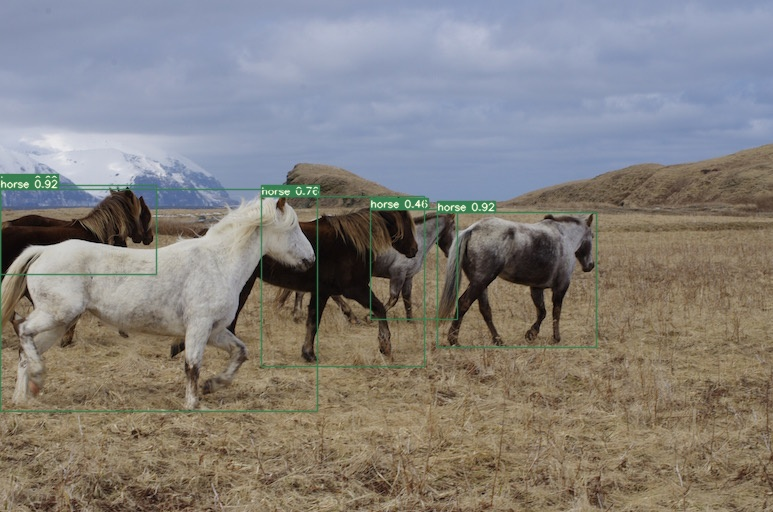

In [5]:
from PIL import Image
# visualize prediction result
Image.open('runs/detect/exp/horses.jpg')

## Export to ONNX [$\Uparrow$](#Table-of-content:)


To export an ONNX format of the model, we will use `export.py` script. Let us check its arguments.

In [6]:
!python export.py --help

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
usage: export.py [-h] [--weights WEIGHTS] [--img-size IMG_SIZE [IMG_SIZE ...]]
                 [--batch-size BATCH_SIZE] [--dynamic] [--dynamic-batch]
                 [--grid] [--end2end] [--max-wh MAX_WH] [--topk-all TOPK_ALL]
                 [--iou-thres IOU_THRES] [--conf-thres CONF_THRES]
                 [--device DEVICE] [--simplify] [--include-nms] [--fp16]
                 [--int8]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS     weights path
  --img-size IMG_SIZE [IMG_SIZE ...]
                        image size
  --batch-size BATCH_SIZE
                        batch size
  --dynamic             dynamic ONNX axes
  --dynamic-batch       dynamic batch onnx for tensorrt and onnx-runtime
  --grid                export Detect() layer grid
  --end2end             export end2end onnx
  --max-wh MAX_WH       None for tensorrt nms, int value for onnx-runtime nms

The most important parameters:

* `--weights` - path to model weights checkpoint
* `--img-size` - size of input image for onnx tracing

When exporting the ONNX model from PyTorch, there is an opportunity to setup configurable parameters for including post-processing results in model:

* `--end2end` - export full model to onnx including post-processing
* `--grid` - export Detect layer as part of model
* `--topk-all` - top k elements for all images
* `--iou-thres` - intersection over union threshold for NMS
* `--conf-thres` - minimal confidence threshold
* `--max-wh` - max bounding box width and height for NMS

Including whole post-processing to model can help to achieve more performant results, but in the same time it makes the model less flexible and does not guarantee full accuracy reproducibility.
It is the reason why we will add only `--grid` parameter to preserve original pytorch model result format.
If you want to understand how to work with an end2end ONNX model, you can check this [notebook](https://github.com/WongKinYiu/yolov7/blob/main/tools/YOLOv7onnx.ipynb).

In [7]:
!python -W ignore export.py --weights model/yolov7-tiny.pt --grid

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(batch_size=1, conf_thres=0.25, device='cpu', dynamic=False, dynamic_batch=False, end2end=False, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.45, max_wh=None, simplify=False, topk_all=100, weights='model/yolov7-tiny.pt')
YOLOR 🚀 v0.1-126-g84932d7 torch 1.13.1+cpu CPU

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 6219709 gradients

Starting TorchScript export with torch 1.13.1+cpu...
TorchScript export success, saved as model/yolov7-tiny.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.13.1+cpu...
TorchScript-Lite export success, saved as model/yolov7-tiny.torchscript.ptl

Starting ONNX export with onnx 1.14.0...
ONNX export success, saved as model/yolov7-tiny.onnx

Export complete (2.86s). Visualize with https://github.com/lutzroeder/netron.


## Convert ONNX Model to OpenVINO Intermediate Representation (IR) [$\Uparrow$](#Table-of-content:)
While ONNX models are directly supported by OpenVINO runtime, it can be useful to convert them to IR format to take the advantage of OpenVINO optimization tools and features.
The `mo.convert_model` python function in OpenVINO Model Optimizer can be used for converting the model.
The function returns instance of OpenVINO Model class, which is ready to use in Python interface. However, it can also be serialized to OpenVINO IR format for future execution.

In [8]:
from openvino.tools import mo
from openvino.runtime import serialize

model = mo.convert_model('model/yolov7-tiny.onnx')
# serialize model for saving IR
serialize(model, 'model/yolov7-tiny.xml')

## Verify model inference [$\Uparrow$](#Table-of-content:)

To test model work, we create inference pipeline similar to `detect.py`. The pipeline consists of preprocessing step, inference of OpenVINO model, and results post-processing to get bounding boxes.

### Preprocessing [$\Uparrow$](#Table-of-content:)

Model input is a tensor with the `[1, 3, 640, 640]` shape in `N, C, H, W` format, where

* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range.
To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved. It is defined in yolov7 repository.

To keep specific shape, preprocessing automatically enables padding.

In [9]:
import numpy as np
import torch
from PIL import Image
from utils.datasets import letterbox
from utils.plots import plot_one_box


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]
    
    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements. 
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range
    
    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']

# colors for visualization
COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(NAMES)}

### Postprocessing [$\Uparrow$](#Table-of-content:)

Model output contains detection boxes candidates. It is a tensor with the `[1,25200,85]` shape in the `B, N, 85` format, where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has the [`x`, `y`, `h`, `w`, `box_score`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `box_score` - confidence of detection box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum suppression algorithm and rescale boxes coordinates to original image size.

In [10]:
from typing import List, Tuple, Dict
from utils.general import scale_coords, non_max_suppression
from openvino.runtime import Model


def detect(model: Model, image_path: Path, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = None, agnostic_nms: bool = False):
    """
    OpenVINO YOLOv7 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label] 
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

In [11]:
from openvino.runtime import Core
core = Core()
# read converted model
model = core.read_model('model/yolov7-tiny.xml')

### Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [12]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [13]:
# load model on CPU device
compiled_model = core.compile_model(model, device.value)

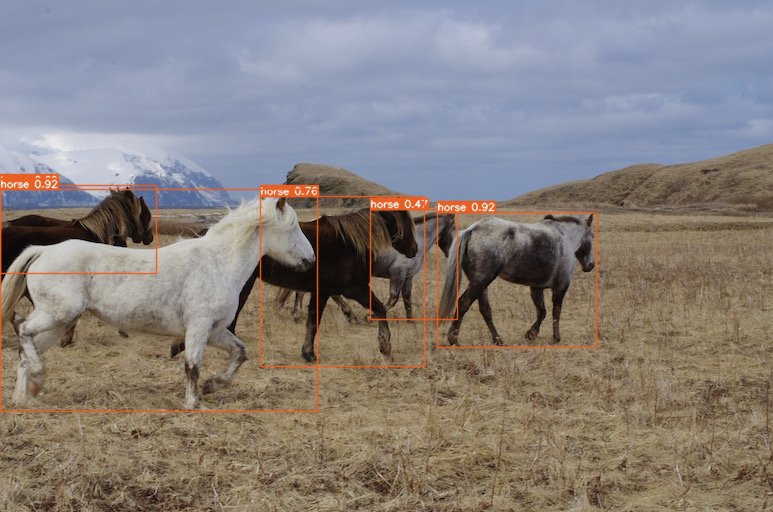

In [14]:
boxes, image, input_shape = detect(compiled_model, 'inference/images/horses.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
# visualize results
Image.fromarray(image_with_boxes)

## Verify model accuracy [$\Uparrow$](#Table-of-content:)


### Download dataset [$\Uparrow$](#Table-of-content:)

YOLOv7 tiny is pre-trained on the COCO dataset, so in order to evaluate the model accuracy, we need to download it. According to the instructions provided in the YOLOv7 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation scripts.

In [15]:
from zipfile import ZipFile

sys.path.append("../../utils")
from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('.')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile('val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

### Create dataloader [$\Uparrow$](#Table-of-content:)


In [16]:
from collections import namedtuple
import yaml
from utils.datasets import create_dataloader
from utils.general import check_dataset, box_iou, xywh2xyxy, colorstr

# read dataset config
DATA_CONFIG = 'data/coco.yaml'
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
TASK = 'val'  # path to train/val/test images
Option = namedtuple('Options', ['single_cls'])  # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(
    data[TASK], 640, 1, 32, opt, pad=0.5,
    prefix=colorstr(f'{TASK}: ')
)[0]

val: Scanning 'coco/val2017' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2548.09it/s]


### Define validation function [$\Uparrow$](#Table-of-content:)

We will reuse validation metrics provided in the YOLOv7 repo with a modification for this case (removing extra steps). The original model evaluation procedure can be found in this [file](https://github.com/WongKinYiu/yolov7/blob/main/test.py)

In [17]:
import numpy as np
from tqdm.notebook import tqdm
from utils.metrics import ap_per_class
from openvino.runtime import Tensor


def test(data,
         model: Model,
         dataloader: torch.utils.data.DataLoader,
         conf_thres: float = 0.001,
         iou_thres: float = 0.65,  # for NMS
         single_cls: bool = False,
         v5_metric: bool = False,
         names: List[str] = None,
         num_samples: int = None
        ):
    """
    YOLOv7 accuracy evaluation. Processes validation dataset and compites metrics.
    
    Parameters:
        model (Model): OpenVINO compiled model.
        dataloader (torch.utils.DataLoader): validation dataset.
        conf_thres (float, *optional*, 0.001): minimal confidence threshold for keeping detections
        iou_thres (float, *optional*, 0.65): IOU threshold for NMS
        single_cls (bool, *optional*, False): class agnostic evaluation
        v5_metric (bool, *optional*, False): use YOLOv5 evaluation approach for metrics calculation
        names (List[str], *optional*, None): names for each class in dataset
        num_samples (int, *optional*, None): number samples for testing
    Returns:
        mp (float): mean precision
        mr (float): mean recall
        map50 (float): mean average precision at 0.5 IOU threshold
        map (float): mean average precision at 0.5:0.95 IOU thresholds
        maps (Dict(int, float): average precision per class
        seen (int): number of evaluated images
        labels (int): number of labels
    """

    model_output = model.output(0)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    if v5_metric:
        print("Testing with YOLOv5 AP metric...")
    
    seen = 0
    p, r, mp, mr, map50, map = 0., 0., 0., 0., 0., 0.
    stats, ap, ap_class = [], [], []
    for sample_id, (img, targets, _, shapes) in enumerate(tqdm(dataloader)):
        if num_samples is not None and sample_id == num_samples:
            break
        img = prepare_input_tensor(img.numpy())
        targets = targets
        height, width = img.shape[2:]

        with torch.no_grad():
            # Run model
            out = torch.from_numpy(model(Tensor(img))[model_output])  # inference output            
            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height])  # to pixels

            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=None, multi_label=True)
        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue
            # Predictions
            predn = pred.clone()
            scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred
            # Assign all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device='cpu')
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]
                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels
                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices
                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices
                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break
            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=True, v5_metric=v5_metric, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return mp, mr, map50, map, maps, seen, nt.sum()

Validation function reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects.
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where `t` is Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, `mAP@.5` indicates that mean average precision calculated at 0.5 IOU threshold, `mAP@.5:.95` - calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

In [18]:
mp, mr, map50, map, maps, num_images, labels = test(data=data, model=compiled_model, dataloader=dataloader, names=NAMES)
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

  0%|          | 0/5000 [00:00<?, ?it/s]

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.651       0.506       0.544       0.359


## Optimize model using NNCF Post-training Quantization API [$\Uparrow$](#Table-of-content:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv7.

> **Note**: NNCF Post-training Quantization is available as a preview feature in OpenVINO 2022.3 release. Fully functional support will be provided in the next releases.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize an OpenVINO IR model, using the `openvino.runtime.serialize` function.

Reuse validation dataloader in accuracy testing for quantization.
For that, it should be wrapped into the `nncf.Dataset` object and define transformation function for getting only input tensors.

In [19]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img) 
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


The `nncf.quantize` function provides interface for model quantization. It requires instance of OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided.
YOLOv7 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve better result, we will use `mixed` quantization preset.
It provides symmetric quantization of weights and asymmetric quantization of activations.

In [20]:
quantized_model = nncf.quantize(model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

serialize(quantized_model, 'model/yolov7-tiny_int8.xml')

Biases correction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 16.41it/s]


## Validate Quantized model inference [$\Uparrow$](#Table-of-content:)


In [21]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

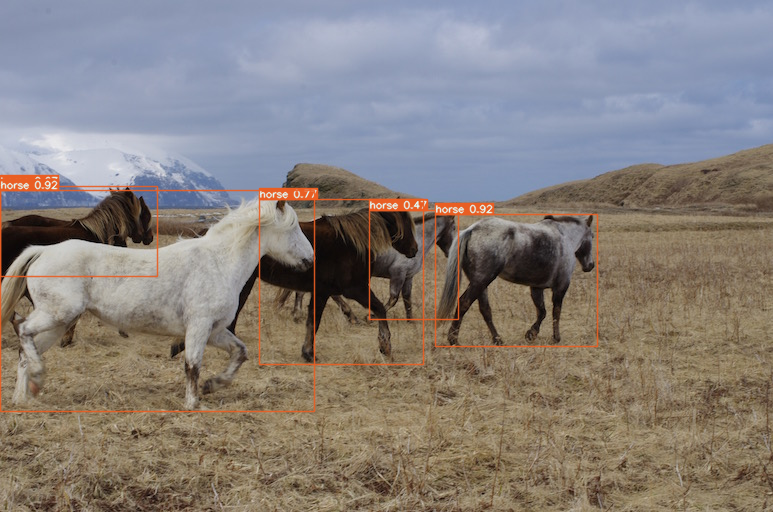

In [22]:
int8_compiled_model = core.compile_model(quantized_model, device.value)
boxes, image, input_shape = detect(int8_compiled_model, 'inference/images/horses.jpg')
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES, COLORS)
Image.fromarray(image_with_boxes)

## Validate quantized model accuracy [$\Uparrow$](#Table-of-content:)


In [23]:
int8_result = test(data=data, model=int8_compiled_model, dataloader=dataloader, names=NAMES)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [24]:
mp, mr, map50, map, maps, num_images, labels = int8_result
# Print results
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
print(s)
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
print(pf % ('all', num_images, labels, mp, mr, map50, map))

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.644       0.504        0.54       0.353


As we can see, model accuracy slightly changed after quantization. However, if we look at the output image, these changes are not significant.

## Compare Performance of the Original and Quantized Models [$\Uparrow$](#Table-of-content:)
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the `FP32` and `INT8` models.

> **NOTE**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [25]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [26]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny.xml -d $device.value -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10862-40bf400b189
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.0.0-10862-40bf400b189
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 12.29 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output (node: output) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ IN

In [27]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny_int8.xml -d $device.value -api async

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.0.0-10862-40bf400b189
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.0.0-10862-40bf400b189
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 20.43 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: images) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     output (node: output) : f32 / [...] / [1,25200,85]
[Step 5/11] Resizing model to match image sizes and given batch
[ IN